(<Figure size 360x360 with 9 Axes>,
 array([[<AxesSubplot:title={'center':'学習データ'}>,
         <AxesSubplot:title={'center':'入力データ'}>,
         <AxesSubplot:title={'center':'出力データ'}>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

c:\Users\atsuy\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\atsuy\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 32722 (\N{CJK UNIFIED IDEOGRAPH-7FD2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\atsuy\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12487 (\N{KATAKANA LETTER DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\atsuy\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\atsuy\AppData\Local\Programs\Python\Python310\lib\site-pack

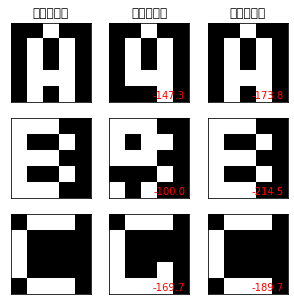

In [1]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals, division

import numpy as np
np.random.seed(1)
from matplotlib import pyplot as plt
import matplotlib.cm as cm


class HopfieldNetwork(object):
    threshold = 0

    def fit(self, train_list):
        """
        初期化: 学習データから重み行列を初期化
        """
        self.dim = len(train_list[0])

        n = len(train_list)
        self.W = np.zeros((self.dim, self.dim))
        rho = np.sum([np.sum(t) for t in train_list]) / (n * self.dim)
        for m in range(n):
            # データ全体の平均値にあわせてシフト
            t = train_list[m] - rho
            self.W += np.outer(t, t)
        for i in range(self.dim):
            self.W[i, i] = 0
        self.W /= n

    def predict(self, data, threshold=0, loop=10):
        """
        更新: 入力値のリストに対し、出力値のリストを返す
        """
        self.threshold = threshold
        return [self._predict(d, loop=loop) for d in data]

    def _predict(self, xr, loop=10):
        """
        個々の入力値に対し、ユニットの値が収束するまで =
        エネルギーが変化しなくなるまで更新を行う
        """
        e = self.energy(xr)
        for i in range(loop):
            xr = self.W.dot(xr) - self.threshold
            # xr の符号をとる
            xr = np.sign(xr)
            e_new = self.energy(xr)
            if e == e_new:
                return xr
            e = e_new
        return xr

    def energy(self, xr):
        """
        ユニットの状態からネットワークのエネルギーを計算
        """
        return - xr.dot(self.W).dot(xr) + np.sum(xr * self.threshold)

    def plot_weight(self):
        """
        重み行列をヒートマップとしてプロット
        """
        fig, ax = plt.subplots(figsize=(5, 3))
        heatmap = ax.pcolor(self.W, cmap=cm.coolwarm)
        cbar = plt.colorbar(heatmap)

        ax.set_xlim(0, self.dim)
        ax.set_ylim(0, self.dim)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        return fig, ax

    def plot_data(self, ax, data, with_energy=False):
        """
        data を画像化 (2次元化) して ax にプロット
        """
        dim = int(np.sqrt(len(data)))
        # このサンプルで扱う画像は縦横 同じ長さのもののみ
        assert dim * dim == len(data)

        img = (data.reshape(dim, dim) + 1) / 2
        ax.imshow(img, cmap=cm.Greys_r, interpolation='nearest')
        if with_energy:
            e = np.round(self.energy(data), 1)
            ax.text(0.95, 0.05, e, color='r', ha='right',
                    transform=ax.transAxes)
        return ax


# ユーティリティ関数

def get_corrupted_input(input, corruption_level):
    """
    入力にノイズを付与
    """
    corrupted = np.copy(input)
    inv = np.random.binomial(n=1, p=corruption_level, size=len(input))
    for i, v in enumerate(input):
        if inv[i]:
            corrupted[i] = -1 * v
    return corrupted

def plot(hn, data, test, predicted, figsize=(5, 7)):
    """
    元データ、テストデータ、推測値を描画
    """
    fig, axes = plt.subplots(len(data), 3, figsize=figsize)
    for i, axrow in enumerate(axes):
        if i == 0:
            axrow[0].set_title('学習データ')
            axrow[1].set_title('入力データ')
            axrow[2].set_title('出力データ')
        hn.plot_data(axrow[0], data[i])
        hn.plot_data(axrow[1], test[i], with_energy=True)
        hn.plot_data(axrow[2], predicted[i], with_energy=True)

        for ax in axrow:
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
    return fig, axes

data = [np.array([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
                  0, 1, 1, 1, 0, 0, 1, 0, 1, 0]),
        np.array([1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
                  1, 0, 0, 1, 0, 1, 1, 1, 0, 0]),
        np.array([0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
                  1, 0, 0, 0, 0, 0, 1, 1, 1, 0])]
data = [d * 2 - 1 for d in data]

# Hopfield Network インスタンスの作成 & 学習
hn = HopfieldNetwork()
hn.fit(data)

# 画像に 10% のノイズを付与し、テストデータとする
test = [get_corrupted_input(d, 0.1) for d in data]
# Hopfield Network からの出力
predicted = hn.predict(test)

plot(hn, data, test, predicted, figsize=(5, 5))

In [2]:
# -*- coding: utf-8 -*-
import argparse
import copy

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import *
from tqdm import tqdm


class Hopfield:
    def __init__(self, train_data, args):
        self.train_data = train_data[:, :args.train_num]
        self.train_num = args.train_num
        self.data_size = int(np.sqrt(train_data.shape[0]))
        self.noise = args.noise
        self.loop_update = args.loop_update
        self.loop_test = args.loop_test
        self.syn = args.syn
        self.W = np.zeros((63, 63))

        # トレーニングデータのプロット
        self.plot(self.train_data.T, 'train_data')

    # エネルギー計算の関数
    def energy(self, x):
        # V = -1/2 * ΣΣ w*x*x
        return -0.5*np.dot(x.T, np.dot(self.W, x))

    # 類似度（距離）計算
    def distance(self, x):
        # 対象データと訓練データの差を計算
        x = x.reshape(self.data_size * self.data_size, 1)
        dis = np.sum(np.abs(self.train_data - x), axis=0) / 2

        # 最小の距離とそのインデックスを取り出す
        sim = np.min(dis)
        simidx = np.argmin(dis)
        # print('train model = {0}, distance = {1}'.format(simidx, sim))
        return sim, simidx

    # テストデータの作成
    def test_make(self, test_idx):
        x_test = copy.deepcopy(self.train_data[:, test_idx])
        # 確率rateで符号を反転させる
        flip = choice([1, -1], self.data_size * self.data_size, p=[1 - self.noise, self.noise])
        x_test = x_test * flip

        return x_test

    # トレーニングデータによる学習
    def fit(self):
        self.W = np.dot(self.train_data, self.train_data.T)/self.train_num  # W = Σ x*x^T
        for i in range(self.data_size * self.data_size):
            self.W[i, i] = 0  # 対角成分0

        return self.W

    # テストデータを使って想起(非同期更新)
    def predict_asyn(self, test_data):
        for _ in range(self.loop_update):
            num = randint(self.data_size*self.data_size)
            test_data[num] = np.sign(np.dot(self.W[num], test_data))

        return test_data

    # 同期更新
    def predict_syn(self, test_data):
        e_old = float("inf")
        for _ in range(self.loop_update):
            # テストデータの更新とエネルギーの計算
            test_data = np.sign(np.dot(self.W, test_data))
            e_new = self.energy(test_data)

            # エネルギーが変化しなくなったら打ち切り
            if e_new == e_old:
                break

            e_old = e_new

        return test_data

    # 描画
    def plot(self, data, name='example'):
        for i in range(len(data)):
            train_graph = data[i].reshape(self.data_size, self.data_size)
            plt.subplot(1, len(data), i + 1)
            plt.imshow(train_graph, cmap=cm.Greys_r, interpolation='nearest')
            plt.title(f'data{i+1}')

        plt.show()
        # plt.savefig('fig/{}.png'.format(name))

    def run(self, test_idx):
        dis = 0  # 正解と異なるマスの数
        acc = 0  # 正解率

        # 訓練データから重み行列の計算
        self.W = self.fit()

        for l in tqdm(range(self.loop_test)):
            # テストデータの作成
            test_data = self.test_make(test_idx)
            # self.plot(test_data.reshape(1, -1), 'test_{:04d}_data'.format(l))

            # テストデータからの想起
            test_predict = self.predict_syn(test_data) if self.syn else self.predict_asyn(test_data)
            # self.plot(test_data.reshape(1, -1), 'test_{:04d}_after'.format(l))

            # 正答率，距離の計算
            _dis, _ = self.distance(test_predict)
            dis += _dis
            if _dis == 0:
                acc += 1

            # print(_dis, acc)

        dis /= self.loop_test
        acc /= float(self.loop_test)
        print("distance = {0}".format(dis))
        print("accuracy = {0}".format(acc))


def main():
    parser = argparse.ArgumentParser(description='hopfield')
    parser.add_argument('--loop_update', type=int, default=300)  # 想起の最大回数
    parser.add_argument('--loop_test', type=int, default=100)  # テスト回数
    parser.add_argument('--noise', type=float, default=0.2)  # ノイズの割合（0~1)
    parser.add_argument('--syn', type=bool, default=False)  # 同期更新，非同期更新
    parser.add_argument('--train_data', type=str, default="src/numbers.npy")  # 訓練データのパス
    parser.add_argument('--train_num', type=int, default=2)  # 記憶パターンの数
    parser.add_argument('--test_idx', type=int, default=0)  # テストデータとする記憶パターンの番号
    args = parser.parse_args()

    # トレーニングデータ読み込み(6*25)
    train_data = np.load(args.train_data).astype(np.float32)
    train_data = train_data.T

    hop = Hopfield(train_data, args)
    hop.run(args.test_idx)


if __name__ == '__main__':
    main()

usage: ipykernel_launcher.py [-h] [--loop_update LOOP_UPDATE]
                             [--loop_test LOOP_TEST] [--noise NOISE]
                             [--syn SYN] [--train_data TRAIN_DATA]
                             [--train_num TRAIN_NUM] [--test_idx TEST_IDX]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9016 --control=9014 --hb=9013 --Session.signature_scheme="hmac-sha256" --Session.key=b"89b8425b-8308-4c57-8b56-8ff51ba79455" --shell=9015 --transport="tcp" --iopub=9017 --f=c:\Users\atsuy\AppData\Roaming\jupyter\runtime\kernel-v2-17780xVJXQ2Yxo18F.json


SystemExit: 2

c:\Users\atsuy\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
